1. Download the MNIST dataset and create a dataloader that adds gaussian noise to the input images.
2. Design and train an AutoEncoder on the MNIST dataset to denoise the noisy images.
3. Randomly choose one image for each digit and visualize the initial images and their corresponding noisy images and decoded images side by side.
4. Compute latent feature vectors of images. (The output of the encoder network)
5. Use PCA to reduce the dimensionality of latent features to 2 and visualize the data points in a scatter plot. Use a different color for each digit.
6. Repeat the previous step with TSNE.
7. What do you conclude from steps 4 and 5 about the learned latent representation of the data?

Bonus:
1. Create a data loader that rotates input images with a random degree.
2. Design and train a Variational AutoEncoder that gets rotated images as input and outputs an image so that the digit in the image would become horizontal.

Useful links:
- [AE](https://medium.com/@AnasBrital98/autoencoders-explained-da131e60e02a)
- [VAE](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)
- [PCA](https://towardsdatascience.com/the-most-gentle-introduction-to-principal-component-analysis-9ffae371e93b#:~:text=From%20Wikipedia%2C%20PCA%20is%20a,find%20unmeasured%20%E2%80%9Clatent%20variables%E2%80%9D.)
- [T-SNE](https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a)

In [1]:
#parts of this code were prepared using some help from github copilot

import random
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
batch_size = 128
num_epochs = 10 # feel free to change this as you please!
learning_rate = 1e-3

train_dataset = datasets.MNIST(root='../../data/',
                                 train=True,
                                    transform=transforms.ToTensor(),
                                    download=True)

test_dataset = datasets.MNIST(root='../../data/',
                                train=False,
                                transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                             batch_size=batch_size,
                                                shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False)


In [2]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                                weight_decay=1e-5)

for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img).cuda()
        output = model(img)
        loss = criterion(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'
            .format(epoch+1, num_epochs, loss.item()))
    

model.eval()
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img).cuda()
        output = model(img)
        loss = criterion(output, img)
        break

epoch [1/10], loss:0.0544
epoch [2/10], loss:0.0518
epoch [3/10], loss:0.0459
epoch [4/10], loss:0.0457
epoch [5/10], loss:0.0451
epoch [6/10], loss:0.0417
epoch [7/10], loss:0.0388
epoch [8/10], loss:0.0406
epoch [9/10], loss:0.0403
epoch [10/10], loss:0.0387


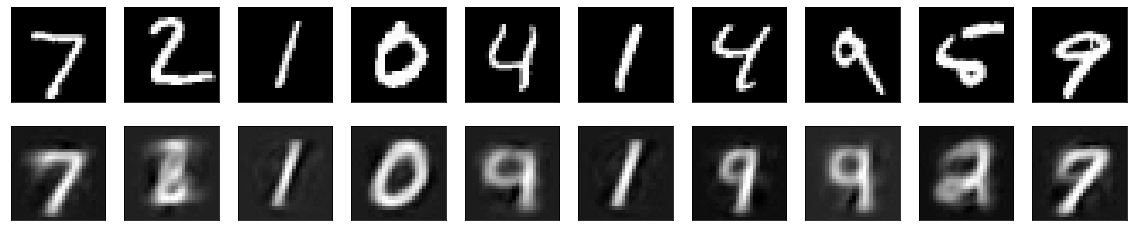

In [3]:
# plt.plot(loss)
# plt.show()
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(img.cpu().data[i].view(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(output.cpu().data[i].view(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

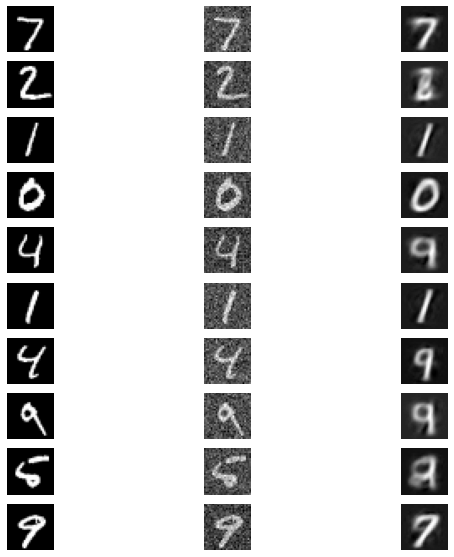

In [4]:

random.seed(0)
random_images = []
for i in range(10):
    random_images.append(random.choice(test_dataset[i][0]))

noisy_images = []
for img in random_images:
    noisy_images.append(img + torch.randn(img.size()) * 0.2)
    

model = model.to('cpu')
for i in range(len(noisy_images)):
    noisy_images[i] = noisy_images[i].to('cpu')
    random_images[i] = random_images[i].to('cpu')
    
denoised_images = []
for img in noisy_images:
    denoised_images.append(model(img.view(1, -1)).view(28, 28))
fig, axs = plt.subplots(10, 3, figsize=(10, 10))
for i in range(10):
    axs[i, 0].imshow(random_images[i].numpy().reshape(28, 28), cmap='gray')
    axs[i, 1].imshow(noisy_images[i].numpy().reshape(28, 28), cmap='gray')
    
    axs[i, 2].imshow(denoised_images[i].detach().numpy().reshape(28, 28), cmap='gray')
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
    axs[i, 2].axis('off')
plt.show()





# # Randomly choose one image for each digit
# random.seed(0)
# indices = []
# for i in range(10):
#     indices.append(random.choice(np.where(test_dataset.targets == i)[0]))
    
# # Visualize the initial images and their corresponding noisy images and decoded images side by side
# fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(10, 20))
# for i, idx in enumerate(indices):
#     img = test_dataset.data[idx]
#     img = img.view(img.size(0), -1)
#     img = Variable(img).cuda()
#     output = model(img)
#     img = img.cpu().detach().numpy()
#     output = output.cpu().detach().numpy()
#     img = img.reshape(28, 28)
#     output = output.reshape(28, 28)
#     axes[i, 0].imshow(img, cmap='gray')
#     axes[i, 1].imshow(output, cmap='gray')
#     axes[i, 2].imshow(img - output, cmap='gray')
#     axes[i, 0].set_title('Original')
#     axes[i, 1].set_title('Decoded')
#     axes[i, 2].set_title('Difference')
#     axes[i, 0].axis('off')
#     axes[i, 1].axis('off')
#     axes[i, 2].axis('off')
# plt.tight_layout()
# plt.show()



/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.016s...
[t-SNE] Computed neighbors for 10000 samples in 0.648s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.376683
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.505844
[t-SNE] KL divergence after 300 iterations: 2.275428


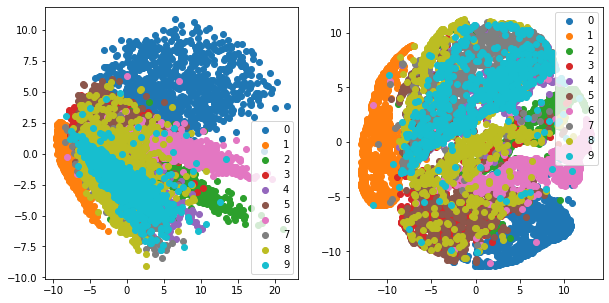

In [5]:

latent_vectors = []
for data in test_loader:
    img, _ = data
    img = img.view(img.size(0), -1)
    img = Variable(img).cuda()
    model = model.to('cpu')
    img = img.to('cpu')
    latent_vectors.append(model.encoder(img).cpu().detach().numpy())

latent_vectors = np.concatenate(latent_vectors, axis=0)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_vectors)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_result = tsne.fit_transform(latent_vectors)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
for i in range(10):
    axs[0].scatter(pca_result[test_dataset.targets == i, 0], pca_result[test_dataset.targets == i, 1], label=str(i))
    axs[1].scatter(tsne_result[test_dataset.targets == i, 0], tsne_result[test_dataset.targets == i, 1], label=str(i))
axs[0].legend()
axs[1].legend()
plt.show()

In [6]:
'''
What do you conclude from steps 4 and 5 about the learned latent representation of the data?
'''
#as you can see in the plots, the learned latent representation of the data is that the digits are well separated from each other. 



'\nWhat do you conclude from steps 4 and 5 about the learned latent representation of the data?\n'

In [14]:
#Bonus :

class RotatedMNIST(datasets.MNIST):
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        angle = random.randint(0, 360)
        img = transforms.ToPILImage()(img)
        img = img.rotate(angle)
        return img, target

In [17]:
# # class VAE(nn.Module):
# #     def __init__(self):
# #         super(VAE, self).__init__()
# #         self.encoder = nn.Sequential(
# #             nn.Linear(784, 400),
# #             nn.ReLU(),
# #             nn.Linear(400, 20)
# #         )
# #         self.decoder = nn.Sequential(
# #             nn.Linear(20, 400),
# #             nn.ReLU(),
# #             nn.Linear(400, 784),
# #             nn.Sigmoid()
# #         )

# #     def forward(self, x):
# #         x = self.encoder(x)
# #         x = self.decoder(x)
# #         return x
    
# # model = VAE().cuda()
# # criterion = nn.MSELoss()
# # optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# # for epoch in range(num_epochs):
# #     for data in train_loader:
# #         img, _ = data
# #         img = img.view(img.size(0), -1)
# #         img = Variable(img).cuda()
# #         output = model(img)
# #         loss = criterion(output, img)
# #         optimizer.zero_grad()
# #         loss.backward()
# #         optimizer.step()
# #     print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
    


# class RotatedVAE(nn.Module):
#     def __init__(self):
#         super(RotatedVAE, self).__init__()

#         self.encoder = nn.Sequential(
#             nn.Linear(784, 400),
#             nn.ReLU(),
#             nn.Linear(400, 20)
#         )

#         self.decoder = nn.Sequential(
#             nn.Linear(20, 400),
#             nn.ReLU(),
#             nn.Linear(400, 784),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x
# model = RotatedVAE().cuda()
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# for epoch in range(num_epochs):
#     for data in train_loader:
#         img, _ = data
#         img = img.view(img.size(0), -1)
#         img = Variable(img).cuda()
#         model = model.to('cpu')
#         img = img.to('cpu')
#         output = model(img)
#         loss = criterion(output, img)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))

class RotatedAutoEncoder(nn.Module):
    def __init__(self):
        super(RotatedAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 400),
            nn.ReLU(True),
            nn.Linear(400, 20),
            nn.ReLU(True),
            nn.Linear(20, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 20),
            nn.ReLU(True),
            nn.Linear(20, 400),
            nn.ReLU(True),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = RotatedAutoEncoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

#train the model
num_epochs = 12 #training this model takes a very long time, you can hava a look at the result of training with 12 epochs below, if you do not have the time for 12 epochs train the model with a smaller number of epochs
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img).cuda()
        model = model.to('cpu')
        img = img.to('cpu')
        output = model(img)
        loss = criterion(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
    

epoch [1/12], loss:0.0524
epoch [2/12], loss:0.0502
epoch [3/12], loss:0.0495
epoch [4/12], loss:0.0486
epoch [5/12], loss:0.0491
epoch [6/12], loss:0.0456
epoch [7/12], loss:0.0426
epoch [8/12], loss:0.0431
epoch [9/12], loss:0.0429
epoch [10/12], loss:0.0407
epoch [11/12], loss:0.0443
epoch [12/12], loss:0.0418


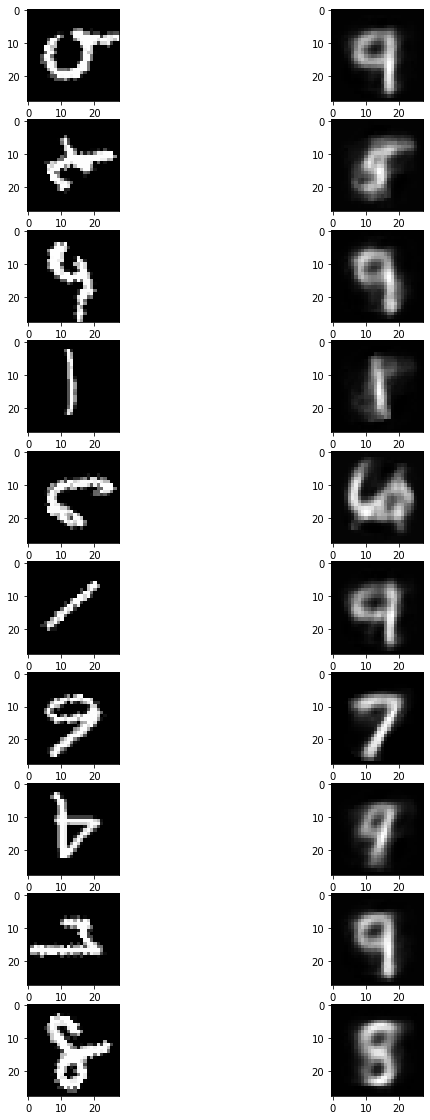

In [23]:

random_images = []
for i in range(10):
    random_index = random.randint(0, len(test_dataset))
    random_image, _ = test_dataset[random_index]
    random_images.append(random_image)

rotated_images = []
for img in random_images:
    angle = random.randint(0, 360)
    rotated_images.append(transforms.ToPILImage()(img).rotate(angle))
    
reconstructed_images = []
for img in rotated_images:
    img = transforms.ToTensor()(img)
    img = img.view(img.size(0), -1)
    img = Variable(img).cuda()
    model = model.to('cpu')
    img = img.to('cpu')
    reconstructed_images.append(model(img).cpu().detach().numpy())

fig, axs = plt.subplots(10, 2, figsize=(10, 20))
for i in range(10):
    axs[i, 0].imshow(rotated_images[i])
    axs[i, 1].imshow(reconstructed_images[i].reshape(28, 28))
plt.show()
